<div class="alert alert-info"> <h1> Notebook to practice Data Pipelines</h1>
<h3> Fetch Data from Earthquake USGov Platform <small><a><code>(http://earthquake.usgs.gov/earthquakes/feed/v1.0/)</code></a></small></h3>
<h3>Fetch additional Data from other random Sources

In [26]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import folium
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [49]:
def url2csv(url, save_path=None):

    data = pd.read_csv(url)
    d = data.copy()
    return d


url = 'http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_day.csv'
df = pd.DataFrame(url2csv(url))


df.head()

features = ['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'place', 'type', 'locationSource', 'magSource']
df = df[features].dropna()
df['time'] = pd.to_datetime(df['time'])
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['year'] = df['time'].dt.year
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute


#drop locationSource and magSource hence they only provide info on which organization detected the eartquake
df = df.drop(columns=['locationSource', 'magSource', 'magType'])

#extract Country form "location"
df['Country'] = df['place'].str.split(',').str[-1].str.strip()


In [61]:
def classify_mag(x):
    if x>=8.0:
        cat = 'great'
    elif (x >= 7.0) and (x < 8.0):
        cat = 'major'
    elif (x >= 6.0) and (x < 7.0):
        cat = 'strong'
    elif (x >= 5.0) and (x < 6.0):
        cat = 'moderate'
    elif (x>= 4.0) and (x < 5.0):
        cat = 'light'
    elif (x >= 2.0) and (x < 4.0):
        cat = 'minor'
    else:
        cat = 'micro'
    return cat

df['magClass'] = df['mag'].apply(classify_mag)

In [62]:
df.head()

,time,latitude,longitude,depth,mag,place,type,month,day,year,hour,minute,Country,magClass
0,2025-01-13 16:35:21.547000+00:00,-18.122300,-178.3047,493.066,4.70,"251 km E of Levuka, Fiji",earthquake,1,13,2025,16,35,Fiji,light
1,2025-01-13 16:14:57.235000+00:00,32.064100,131.6975,35.000,5.20,"20 km ESE of Takanabe, Japan",earthquake,1,13,2025,16,14,Japan,moderate
2,2025-01-13 15:48:41.060000+00:00,19.023333,-67.6595,25.080,3.19,"83 km NW of San Antonio, Puerto Rico",earthquake,1,13,2025,15,48,Puerto Rico,minor
3,2025-01-13 15:44:42.604000+00:00,28.416900,87.1257,10.000,4.60,"60 km NNE of Lobuche, Nepal",earthquake,1,13,2025,15,44,Nepal,light
4,2025-01-13 15:19:08.164000+00:00,28.347000,87.2123,10.000,4.30,"59 km NE of Lobuche, Nepal",earthquake,1,13,2025,15,19,Nepal,light


<div class="alert alert-info"> <h3> visualize where the most earthquakes appear

In [64]:
plt.figure(figsize=(8, 6))
countries  = df['Country'].value_counts()

sns.barplot(x=countries.index, y=countries.values, hue=df['magClass'], palette='colorblind')

plt.title("Distribution of Earthquakes after Countries")
plt.xlabel("Countries")
plt.ylabel("Frequency")
plt.show()


ValueError: array length 18 does not match index length 41

<Figure size 800x600 with 0 Axes>

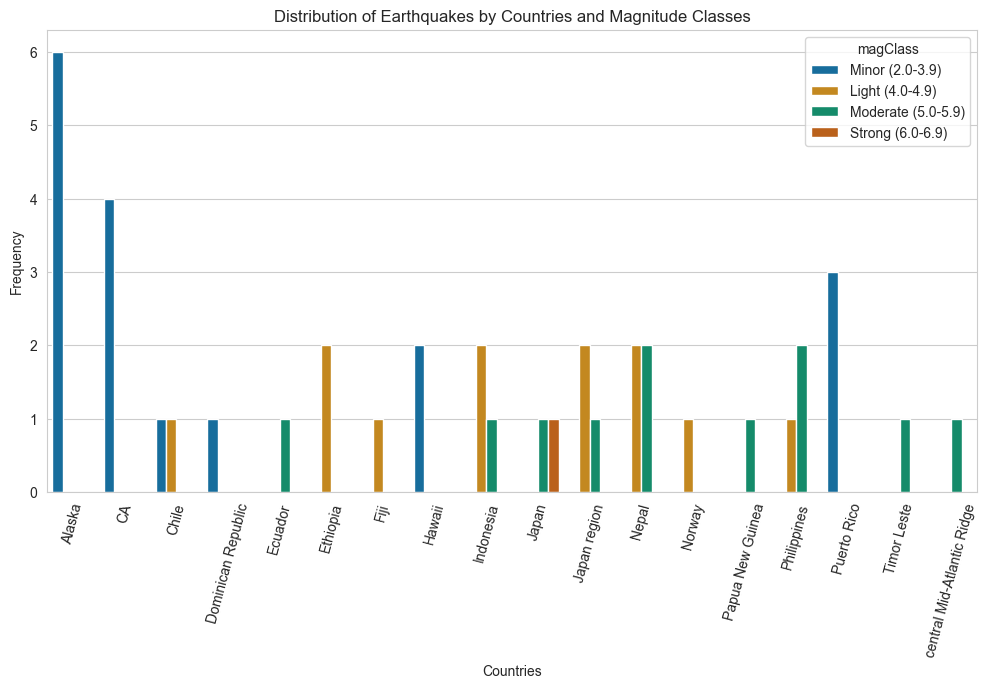

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Angenommene Struktur des DataFrames df
# df = pd.DataFrame({'Country': ['USA', 'Nepal', 'USA', 'Nepal', 'Chile', ...], 'magClass': ['Moderate', 'Light', 'Strong', 'Light', 'Major', ...]})

# Beispiel: categorize_magnitude-Funktion, falls noch nicht implementiert:
def categorize_magnitude(mag):
    if mag < 2.0:
        return 'Micro (<2.0)'
    elif 2.0 <= mag < 4.0:
        return 'Minor (2.0-3.9)'
    elif 4.0 <= mag < 5.0:
        return 'Light (4.0-4.9)'
    elif 5.0 <= mag < 6.0:
        return 'Moderate (5.0-5.9)'
    elif 6.0 <= mag < 7.0:
        return 'Strong (6.0-6.9)'
    elif 7.0 <= mag < 8.0:
        return 'Major (7.0-7.9)'
    else:
        return 'Great (≥8.0)'

# Sicherstellen, dass 'magClass' vorhanden ist
df['magClass'] = df['mag'].apply(categorize_magnitude)

# Erstelle eine neue DataFrame, die Häufigkeit von Ländern und 'magClass' zählt
country_magClass_counts = df.groupby(['Country', 'magClass']).size().reset_index(name='count')

# Erstelle das Plot
plt.figure(figsize=(12, 6))

# Erstelle das Barplot
sns.barplot(x='Country', y='count', hue='magClass', data=country_magClass_counts, palette='colorblind')

# Titel und Achsenbeschriftungen
plt.title("Distribution of Earthquakes by Countries and Magnitude Classes")
plt.xlabel("Countries")
plt.ylabel("Frequency")
plt.xticks(rotation=75)  # Dreht die X-Achsen-Beschriftungen, um sie lesbar zu machen
plt.show()

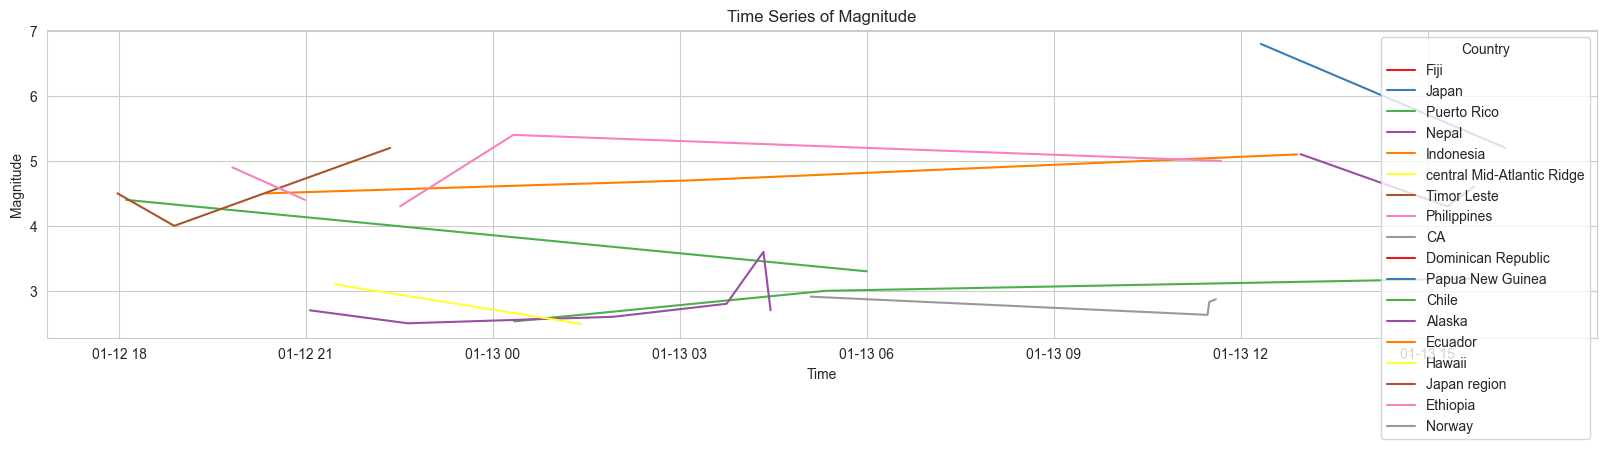

In [71]:
plt.figure(figsize=(20, 4))
sns.lineplot(x='time', y='mag', hue='Country', data=df, palette='Set1')
plt.title("Time Series of Magnitude")
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.show()

<div class="alert alert-info"> <h2> Visualize Earthquake Locations on Map

In [63]:

# Initiale Karte
map_center = [df['latitude'].mean(), df['longitude'].mean()]
earthquake_map = folium.Map(location=map_center, zoom_start=6)

# Punkte hinzufügen
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['mag'],  # Magnitude als Markergröße
        popup=f"Place: {row['place']}\nMagnitude: {row['mag']}",
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(earthquake_map)

earthquake_map.save('earthquake_map.html')


0    Nepal
1    Nepal
2    Nepal
Name: Country, dtype: object

<div class="alert alert-info"> <h3> visualize the result from <code>TfidVectorizer()</code>

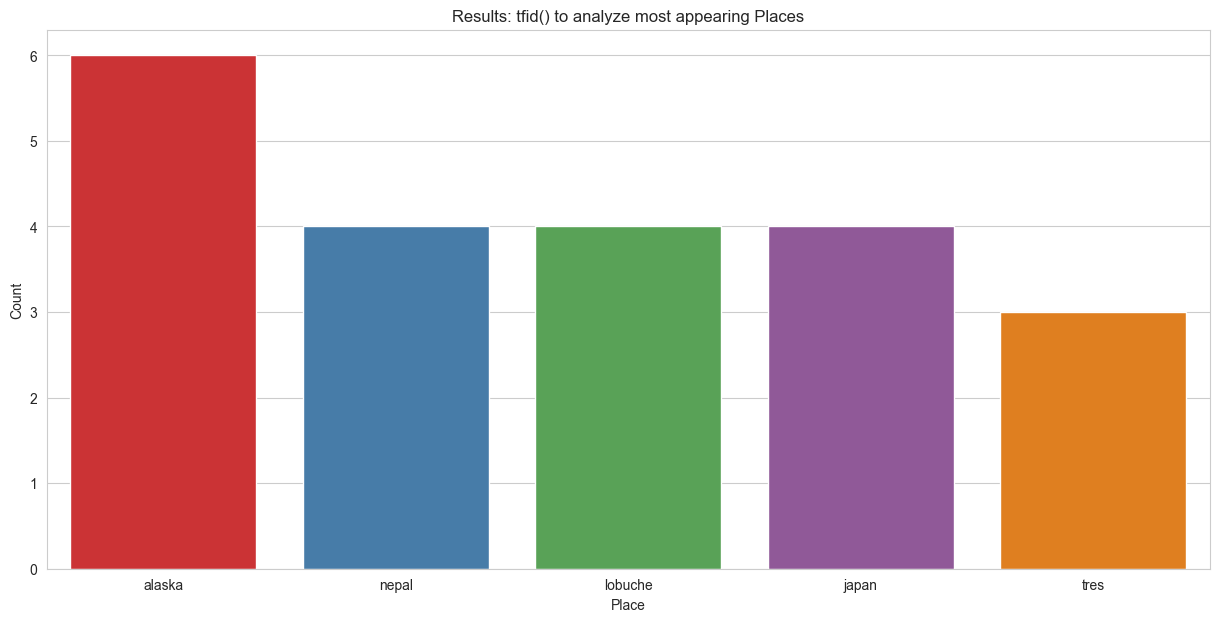

In [42]:
plt.figure(figsize=(15, 7))
sns.barplot(data=word_freq.head(5), x='word', y='count', hue='word', palette='Set1')
plt.title("Results: tfid() to analyze most appearing Places")
plt.xlabel('Place')
plt.ylabel('Count')
plt.show()